# 영업 성공 여부 분류 경진대회

## 1. 데이터 확인

### 필수 라이브러리

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 데이터 셋 읽어오기

In [2]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [3]:
df_train # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.00,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.00,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.00,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.00,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.00,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,/Sląskie/Poland,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,...,LGEPL,3 months ~ 6 months,0,0,0.000026,0.028777,public facility,Others,694,False
59295,0.75,/Bogotá DC /Colombia,AS,0.040000,35420,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGECB,9 months ~ 1 year,0,0,0.000026,0.028777,public facility,NaN,39,False
59296,0.75,/Pisco/Peru,AS,0.040000,19249,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEPR,less than 3 months,0,0,0.000026,0.028777,public facility,NaN,125,False
59297,1.00,/santa cruz bolivia/Peru,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,...,LGEPR,more than a year,0,0,0.000026,0.028777,public facility,NaN,134,False


## data 전처리

Customer_country 이상치 전처리 

In [4]:
df_train = df_train[~df_train['customer_country'].str.contains('@',na=False,case=False)]
df_train = df_train[~df_train['customer_country.1'].str.contains('@',na=False,case=False)]
df_train = df_train.drop(['customer_country.1'],axis=1)

Customer_country 세분화

In [5]:
df_train[['city','country']]=df_train['customer_country'].str.strip('/').str.split('/',expand=True, n=1)
df_train['city']=df_train['city'].combine_first(df_train['country'])
df_train['country']=df_train['country'].fillna('')
print(df_train[['country','customer_country','city']])

           country          customer_country                city
0      Philippines  /Quezon City/Philippines         Quezon City
1      Philippines        /PH-00/Philippines               PH-00
2            India           /Kolkata /India            Kolkata 
3            India        /Bhubaneswar/India         Bhubaneswar
4            India          /Hyderabad/India           Hyderabad
...            ...                       ...                 ...
59294       Poland           /Sląskie/Poland             Sląskie
59295     Colombia      /Bogotá DC /Colombia          Bogotá DC 
59296         Peru               /Pisco/Peru               Pisco
59297         Peru  /santa cruz bolivia/Peru  santa cruz bolivia
59298       France             /paris/France               paris

[59223 rows x 3 columns]


In [6]:
df_train = df_train.drop('customer_country',axis=1)
df_train

,bant_submit,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,...,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,city,country
0,1.00,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,Engineering,0,True,Quezon City,Philippines
1,1.00,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,Advertising,1,True,PH-00,Philippines
2,1.00,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,Construction,2,True,Kolkata,India
3,1.00,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True,Bhubaneswar,India
4,1.00,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.003079,0.026846,corporate / office,NaN,4,True,Hyderabad,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,Others,694,False,Sląskie,Poland
59295,0.75,AS,0.040000,35420,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,NaN,39,False,Bogotá DC,Colombia
59296,0.75,AS,0.040000,19249,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,NaN,125,False,Pisco,Peru
59297,1.00,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,NaN,134,False,santa cruz bolivia,Peru


Customer_type전처리

In [7]:
df_train['customer_type'] = df_train['customer_type'].replace('End-Customer','End Customer')
df_train['customer_type'] = df_train['customer_type'].apply(lambda x: x.split('/')[0] if isinstance(x, str) else x)
df_train

,bant_submit,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,...,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,city,country
0,1.00,AS,0.066667,32160,End Customer,Enterprise,NaN,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,Engineering,0,True,Quezon City,Philippines
1,1.00,AS,0.066667,23122,End Customer,Enterprise,12.0,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,Advertising,1,True,PH-00,Philippines
2,1.00,AS,0.088889,1755,End Customer,Enterprise,144.0,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,Construction,2,True,Kolkata,India
3,1.00,AS,0.088889,4919,End Customer,Enterprise,NaN,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True,Bhubaneswar,India
4,1.00,AS,0.088889,17126,Specifier,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.003079,0.026846,corporate / office,NaN,4,True,Hyderabad,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,Others,694,False,Sląskie,Poland
59295,0.75,AS,0.040000,35420,Specifier,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,NaN,39,False,Bogotá DC,Colombia
59296,0.75,AS,0.040000,19249,Specifier,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,NaN,125,False,Pisco,Peru
59297,1.00,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,NaN,134,False,santa cruz bolivia,Peru


In [8]:
df_train = df_train[~df_train.applymap(lambda value: isinstance(value, str) and '???' in value).any(axis=1)]
df_train

/tmp/ipykernel_172/3435863140.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train = df_train[~df_train.applymap(lambda value: isinstance(value, str) and '???' in value).any(axis=1)]


,bant_submit,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,...,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,city,country
0,1.00,AS,0.066667,32160,End Customer,Enterprise,NaN,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,Engineering,0,True,Quezon City,Philippines
1,1.00,AS,0.066667,23122,End Customer,Enterprise,12.0,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,Advertising,1,True,PH-00,Philippines
2,1.00,AS,0.088889,1755,End Customer,Enterprise,144.0,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,Construction,2,True,Kolkata,India
3,1.00,AS,0.088889,4919,End Customer,Enterprise,NaN,NaN,NaN,NaN,...,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True,Bhubaneswar,India
4,1.00,AS,0.088889,17126,Specifier,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.003079,0.026846,corporate / office,NaN,4,True,Hyderabad,India
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59294,1.00,AS,NaN,33747,End Customer,SMB,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,Others,694,False,Sląskie,Poland
59295,0.75,AS,0.040000,35420,Specifier,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,NaN,39,False,Bogotá DC,Colombia
59296,0.75,AS,0.040000,19249,Specifier,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,NaN,125,False,Pisco,Peru
59297,1.00,AS,0.040000,40327,NaN,Enterprise,NaN,NaN,NaN,NaN,...,0,0,0.000026,0.028777,public facility,NaN,134,False,santa cruz bolivia,Peru


## test 값 전처리

In [9]:
df_test = df_test[~df_test['customer_country'].str.contains('@',na=False,case=False)]
df_test = df_test[~df_test['customer_country.1'].str.contains('@',na=False,case=False)]
df_test = df_test.drop(['customer_country.1'],axis=1)
df_test[['city','country']]=df_test['customer_country'].str.strip('/').str.split('/',expand=True, n=1)
df_test['city']=df_test['city'].combine_first(df_train['country'])
df_test['country']=df_test['country'].fillna('')
df_test = df_test.drop('customer_country',axis=1)
df_test['customer_type'] = df_test['customer_type'].replace('End-Customer','End Customer')
df_test['customer_type'] = df_test['customer_type'].apply(lambda x: x.split('/')[0] if isinstance(x, str) else x)
df_test = df_test[~df_test.applymap(lambda value: isinstance(value, str) and '???' in value).any(axis=1)]
df_test

/tmp/ipykernel_172/581850046.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_test = df_test[~df_test.applymap(lambda value: isinstance(value, str) and '???' in value).any(axis=1)]


,id,bant_submit,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,city,country
0,19844,0.00,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,NaN,...,1,0,0.001183,0.049840,retail,Electronics & Telco,278,0,,Brazil
1,9738,0.25,IT,NaN,5405,End Customer,SMB,NaN,NaN,NaN,...,0,0,0.000013,NaN,transportation,Others,437,1,400 N State Of Franklin Rd Cloud IT,Johnson City / United States
2,8491,1.00,ID,NaN,13597,Specifier,SMB,NaN,NaN,NaN,...,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,0,,U.A.E
3,19895,0.50,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,NaN,...,0,0,0.001183,0.049840,retail,NaN,194,0,Madison,United States
4,10465,1.00,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,NaN,...,1,1,0.003079,0.064566,corporate / office,Engineering,167,0,Sao Paulo,Brazil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5266,13855,0.50,AS,NaN,40292,NaN,Enterprise,10.0,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,97,0,São Paulo,Brazil
5267,7979,0.25,IT,NaN,47466,NaN,Enterprise,0.0,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,438,1,General,/ United States
5268,12887,0.75,AS,NaN,46227,Specifier,Enterprise,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,97,0,OURO BRANCO,Brazil
5269,17530,0.00,IT,NaN,45667,End Customer,SMB,NaN,NaN,NaN,...,0,0,NaN,NaN,NaN,NaN,429,0,,Germany


## Y전처리

In [10]:
df_train['is_converted'] = df_train['is_converted'].astype(int)
df_train['is_converted']

0        1
1        1
2        1
3        1
4        1
        ..
59294    0
59295    0
59296    0
59297    0
59298    0
Name: is_converted, Length: 59223, dtype: int64

## 결측치 처리

In [11]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

## 2. 데이터 전처리

### 레이블 인코딩

In [12]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [13]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    "country",
    "city"
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

다시 학습 데이터와 제출 데이터를 분리합니다.

In [14]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

### 2-2. 학습, 검증 데이터 분리

In [15]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop(["is_converted","customer_idx"], axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)
print(x_train)
print(x_val)
print(y_train)
print(y_val)

       bant_submit  business_unit  com_reg_ver_win_rate  customer_idx  \
19830         0.50              0              0.000000         14459   
45461         1.00              0              0.000000         26905   
53363         0.75              0              0.011858         17717   
40447         0.50              0              0.000000          3273   
18604         0.25              0              0.000000         47466   
...            ...            ...                   ...           ...   
140           1.00              0              0.066667         39568   
46082         0.50              0              0.000000         14895   
2378          0.75              2              0.000000         25096   
3547          1.00              2              0.000000         35320   
53671         0.50              2              0.032787          8304   

       customer_type  enterprise  historical_existing_cnt  id_strategic_ver  \
19830              0           1            

## 3. 모델 학습

### 모델 정의 

In [16]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
model = GradientBoostingClassifier()

### 모델 학습

In [ ]:
param = {
    'n_estimators' : [1800],
    'learning_rate' : [0.3],
#     'estimator' : [DecisionTreeClassifier(),RandomForestClassifier()]
    'max_depth' : [15],
}

grid_cv = GridSearchCV(model, param_grid=param, cv=5, verbose=2, n_jobs=-1)
grid_cv.fit(x_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


### 모델 성능 보기

In [19]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [20]:
pred = grid_cv.predict(x_val)
get_clf_eval(y_val, pred)
print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)

오차행렬:
 [[  587   360]
 [  178 10720]]

정확도: 0.9546
정밀도: 0.7673
재현율: 0.6199
F1: 0.6857
최적 하이퍼 파라미터: 
 {'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 1800}


In [21]:
# Train Acc
y_pre_train = grid_cv.predict(x_train)
cm_train = confusion_matrix(y_train, y_pre_train)
print("Train Confusion Matrix")
print(cm_train)
print("Train Acc : {}".format((cm_train[0, 0] + cm_train[1, 1]) / cm_train.sum()))
print("Train F1-Score : {}".format(f1_score(y_train, y_pre_train)))
print("Train AUROC : {}".format(roc_auc_score(y_train, y_pre_train)))

# Test Acc
y_pre_test = grid_cv.predict(x_val)
cm_test = confusion_matrix(y_val, y_pre_test)
print("Test Confusion Matrix")
print(cm_test)
print("TesT Acc : {}".format((cm_test[0, 0] + cm_test[1, 1]) / cm_test.sum()))
print("Test F1-Score : {}".format(f1_score(y_val, y_pre_test)))
print("Test AUROC : {}".format(roc_auc_score(y_val, y_pre_test)))

Train Confusion Matrix
[[43462    13]
 [   46  3857]]
Train Acc : 0.9987546962725316
Train F1-Score : 0.9924096230541619
Train AUROC : 0.9939575858914501
Test Confusion Matrix
[[10720   178]
 [  360   587]]
TesT Acc : 0.9545799915576193
Test F1-Score : 0.6857476635514018
Test AUROC : 0.8017594462853497


## 4. 제출하기

### 테스트 데이터 예측

In [24]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id","customer_idx"], axis=1)

In [25]:
test_pred = grid_cv.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

796

(27,)
(27,)


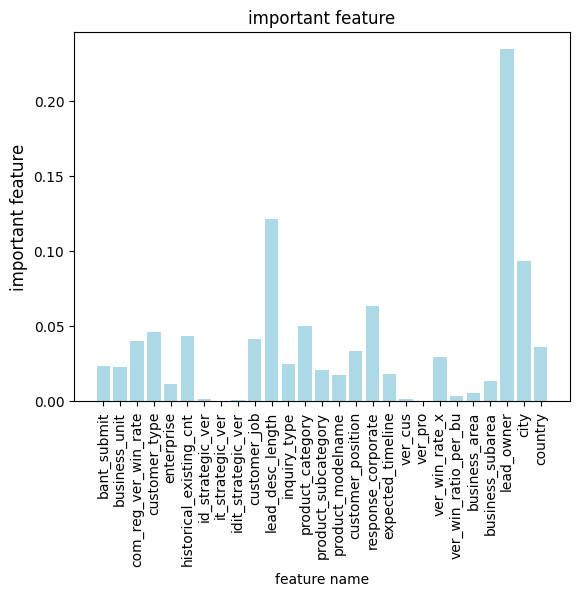

In [26]:
n_feature = df_train.drop(["is_converted","customer_idx"], axis=1).shape[1]
import matplotlib.pyplot as plt
feature_importances = grid_cv.best_estimator_.feature_importances_
index = np.arange(n_feature)
print(feature_importances.shape)
print(index.shape)
plt.bar(index, feature_importances, color='lightblue', align='center')
plt.xticks(index, df_train.drop(["is_converted","customer_idx"], axis=1).columns, rotation=90)
plt.ylabel('important feature', size=12)
plt.xlabel('feature name', size=10)
plt.title('important feature', size=12)
plt.show()

### 제출 파일 작성

In [27]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**